<a href="https://colab.research.google.com/github/codebluecruz/Getting-started-with-github/blob/master/cnn%20lstm%20%2B%20glove%20on%20finalwebmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

## Plot
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'colab'
from plotly.offline import init_notebook_mode, iplot
import matplotlib as plt

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')

# Other
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
test1 = pd.read_csv('/content/drive/My Drive/webmd_firsthalf.csv')

In [6]:
test1=test1.dropna()

In [7]:
test = test1.drop(columns=['Age', 'Condition', 'Date', 'Drug', 'DrugId', 'EaseofUse', 'Effectiveness', 'Sex', 'Sides', 'UsefulCount'])
test.tail()

,Reviews,Satisfaction
99995,I used this medicine for vertigo. It is somewh...,2
99996,when I had to go off of it because my insuranc...,5
99997,,1
99998,I got the mirena in may of 08 after my son was...,1
99999,,5


In [9]:
df=test

In [10]:
df = df.rename(columns={'Reviews': 'text', 'Satisfaction': 'stars'})
df.head()

,text,stars
0,I'm a retired physician and of all the meds I ...,5
1,cleared me right up even with my throat hurtin...,5
2,why did my PTINR go from a normal of 2.5 to ov...,3
3,FALLING AND DON'T REALISE IT,1
4,My grandfather was prescribed this medication ...,1


In [11]:
labels = df['stars'].map(lambda x : 1 if int(x) > 3 else 0)

In [12]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [13]:
df['text'] = df['text'].map(lambda x: clean_text(x))

In [14]:
df.head()

,text,stars
0,i am retir physician med tri allergi season no...,5
1,clear right even throat hurt went away take me...,5
2,ptinr normal 2 5 + 100,3
3,fall realis,1
4,grandfath prescrib medic coumadin assist blood...,1


In [15]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=50)

In [16]:
print(data.shape)

(99988, 50)


# Build neural network with LSTM and CNN
The LSTM model worked well. However, it takes forever to train three epochs. One way to speed up the training time is to improve the network adding “Convolutional” layer. Convolutional Neural Networks (CNN) come from image processing. They pass a “filter” over the data and calculate a higher-level representation. They have been shown to work surprisingly well for text, even though they have none of the sequence processing ability of LSTMs

In [17]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length=50))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_conv

In [18]:
model_conv = create_conv_model()
history_conv=model_conv.fit(data, np.array(labels), validation_split=0.4, epochs = 4)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 59992 samples, validate on 39996 samples
Epoch 1/4
59992/59992 [==============================] - 100s 2ms/step - loss: 0.5403 - accuracy: 0.7168 - val_loss: 0.5885 - val_accuracy: 0.6926
Epoch 2/4
59992/59992 [==============================] - 102s 2ms/step - loss: 0.4187 - accuracy: 0.7972 - val_loss: 0.6151 - val_accuracy: 0.6866
Epoch 3/4
59992/59992 [==============================] - 101s 2ms/step - loss: 0.3200 - accuracy: 0.8451 - val_loss: 0.7486 - val_accuracy: 0.6840
Epoch 4/4
59992/59992 [==============================] - 101s 2ms/step - loss: 0.2575 - accuracy: 0.8721 - val_loss: 0.8309 - val_accuracy: 0.6804


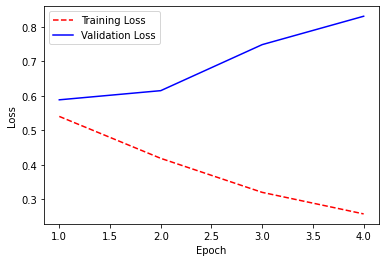

In [19]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history_conv.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history_conv.history['loss'], 'r--')
plt.plot(epoch_count, history_conv.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [20]:
df_save = pd.DataFrame(data)
df_label = pd.DataFrame(np.array(labels))

In [21]:
result = pd.concat([df_save, df_label], axis = 1)

In [28]:
result.to_csv('train_dense_word_vectors_lstm.csv', index=False)

# Use pre-trained Glove word embeddings

### Get embeddings from Glove

In [23]:
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [24]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### Develop model

In [25]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history_glove=model_glove.fit(data, np.array(labels), validation_split=0.4, epochs = 4)

Train on 59992 samples, validate on 39996 samples
Epoch 1/4
59992/59992 [==============================] - 51s 858us/step - loss: 0.6234 - accuracy: 0.6452 - val_loss: 0.6362 - val_accuracy: 0.6283
Epoch 2/4
59992/59992 [==============================] - 50s 826us/step - loss: 0.5739 - accuracy: 0.6925 - val_loss: 0.6165 - val_accuracy: 0.6582
Epoch 3/4
59992/59992 [==============================] - 50s 829us/step - loss: 0.5405 - accuracy: 0.7173 - val_loss: 0.6187 - val_accuracy: 0.6609
Epoch 4/4
59992/59992 [==============================] - 50s 827us/step - loss: 0.5144 - accuracy: 0.7348 - val_loss: 0.6339 - val_accuracy: 0.6605


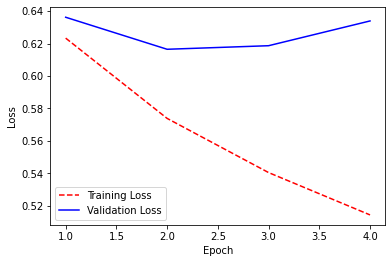

In [27]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history_glove.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history_glove.history['loss'], 'r--')
plt.plot(epoch_count, history_glove.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [29]:
df_save = pd.DataFrame(data)
df_label = pd.DataFrame(np.array(labels))

In [30]:
result = pd.concat([df_save, df_label], axis = 1)

In [31]:
result.to_csv('train_dense_word_vectors_glove.csv', index=False)